In [ ]:
!pip install -q git+https://github.com/ficstamas/data-mining.git

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
import pandas as pd
from ipywidgets import interact, widgets

# from sklearn.decomposition import PCA, TruncatedSVD
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Dimensionality Reduction

In modern data science and machine learning, datasets often have hundreds or thousands of features. While more data can help, high-dimensional datasets introduce several challenges:

1. **Computational Complexity**  
   Algorithms become slower and more memory-intensive as the number of dimensions increases.

2. **Curse of Dimensionality**  
   As dimensionality grows:
   - Data points become sparse in space.
   - Distances between points become less meaningful.
   - Models often overfit due to too many irrelevant features.

3. **Visualization**  
   Human intuition is limited to 2D or 3D. High-dimensional data cannot be visualized directly.

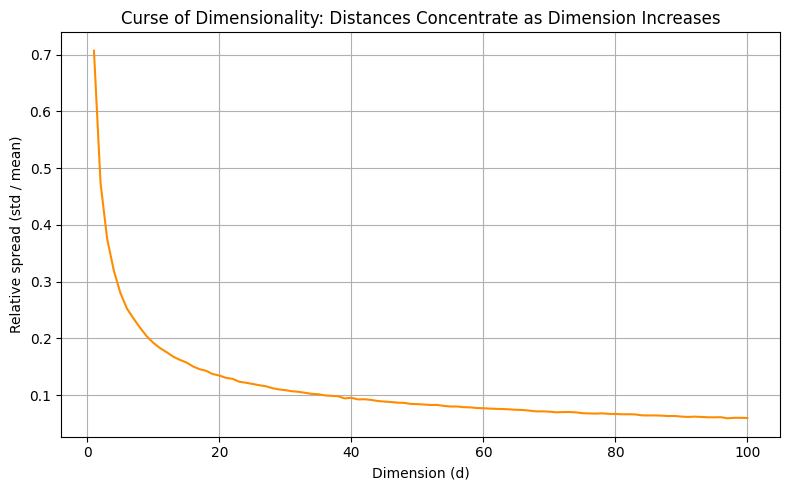

In [2]:
np.random.seed(0)

n_points = 1000
max_dim = 100
dimensions = range(1, max_dim + 1)

mean_distances = []
std_distances = []

for d in dimensions:
    points = np.random.rand(n_points, d)
    # Compute pairwise distances
    dist_matrix = np.sqrt(
        np.sum((points[:, np.newaxis, :] - points[np.newaxis, :, :]) ** 2, axis=-1)
    )
    # Exclude self-distances
    dists = dist_matrix[np.triu_indices(n_points, k=1)]
    
    mean_distances.append(np.mean(dists))
    std_distances.append(np.std(dists))

mean_distances = np.array(mean_distances)
std_distances = np.array(std_distances)

# Relative spread (coefficient of variation)
rel_spread = std_distances / mean_distances

plt.figure(figsize=(8, 5))
plt.plot(dimensions, rel_spread, color="darkorange")
plt.xlabel("Dimension (d)")
plt.ylabel("Relative spread (std / mean)")
plt.title("Curse of Dimensionality: Distances Concentrate as Dimension Increases")
plt.grid(True)
plt.tight_layout()
plt.show()

## What is Dimensionality Reduction?
Dimensionality reduction is the process of transforming high-dimensional data into a **lower-dimensional space** while preserving as much important information as possible.  

Formally, given a dataset:

$$
X \in \mathbb{R}^{n \times d}, \quad n \text{ samples}, d \text{ features}
$$

We aim to find a mapping:

$$
f: \mathbb{R}^d \to \mathbb{R}^k, \quad k \ll d
$$

so that the transformed data $Z = f(X)$ retains the key structure of $X$.

## Types of Dimensionality Reduction

1. **Unsupervised**
   - Uses only the input features.
   - Examples:
     - **PCA (Principal Component Analysis)**: finds directions of maximum variance.
     - **SVD (Singular Value Decomposition)**: factorizes data into orthogonal components.
     - **t-SNE / UMAP**: nonlinear projections for visualization.

2. **Supervised**
   - Uses input features **and labels**.
   - Examples:
     - **LDA (Linear Discriminant Analysis)**: maximizes class separability.
     - **Partial Least Squares (PLS)**: projects features while considering target variables.

| Method  | Supervised? | Objective                   | Geometric intuition                                       |
| ------- | ----------- | --------------------------- | --------------------------------------------------------- |
| **PCA** | No        | Maximize total variance     | Find orthogonal directions of highest variance            |
| **SVD** | No        | Factorize data matrix       | Decompose data into orthogonal basis (for reconstruction) |
| **LDA** | Yes       | Maximize class separability | Find projection that best separates class means           |


# Eigenvalues and Eigenvectors

Eigenvalues and eigenvectors are central concepts in linear algebra that provide deep insights into the behavior of linear transformations represented by matrices. Given a square matrix $A$, an eigenvector $v$ is a non-zero vector that, when multiplied by $A$, only changes in magnitude and not in direction. The factor by which it is scaled is called the eigenvalue $\lambda$, satisfying the equation $Av=\lambda v$. Eigenvalues and eigenvectors reveal fundamental properties of a matrix, such as its invertibility, stability, and the principal directions along which transformations act.

In [ ]:
@interact(
    a11=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1),
    a12=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.5),
    a21=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.5),
    a22=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1),
)
def plot_eigen(a11=2.0, a12=0.0, a21=0.0, a22=1.0):
    A = np.array([[a11, a12],
                  [a21, a22]])
    
    # Create a unit circle
    theta = np.linspace(0, 2*np.pi, 200)
    circle = np.vstack([np.cos(theta), np.sin(theta)])

    # Transform circle
    ellipse = A @ circle
    
    # Try computing eigenvalues/vectors
    try:
        vals, vecs = np.linalg.eig(A)
    except np.linalg.LinAlgError:
        vals, vecs = [], []

    print(vecs)
    
    plt.figure(figsize=(6,6))
    
    # Original circle
    plt.plot(circle[0], circle[1], 'k--', alpha=0.5, label="Unit circle")
    
    # Transformed ellipse
    plt.plot(ellipse[0], ellipse[1], 'b-', label="Transformed circle")
    
    # Plot eigenvectors
    for val, vec in zip(vals, vecs.T):
        if np.iscomplex(val):  # skip complex eigenvalues
            continue
        vec = vec / np.linalg.norm(vec)  # normalize
        plt.arrow(0, 0, val*vec[0], val*vec[1],
                  head_width=0.1, color='r', alpha=0.8,
                  length_includes_head=True)
        plt.text(val*vec[0]*1.1, val*vec[1]*1.1, f"λ={val:.2f}", color='r')
    
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend()
    plt.title(f"Matrix A = [[{a11:.1f}, {a12:.1f}], [{a21:.1f}, {a22:.1f}]]")
    plt.show()

# Principal Component Analysis (PCA)

**Principal Component Analysis (PCA)** is one of the most widely used techniques for **dimensionality reduction**.  

It helps us find a **new set of orthogonal axes** (called **principal components**) that capture the **maximum variance** in the data. By projecting the data onto these axes, we can reduce dimensionality while retaining the most important information.

---

## 🔍 Key Concepts

1. **Variance and Information**  
   - PCA assumes that directions with higher variance contain more “information.”
   - The first principal component is the direction with the largest variance.
   - The second principal component is orthogonal to the first and captures the next largest variance, and so on.

2. **Eigenvectors and Eigenvalues**  
   - PCA is computed by finding **eigenvectors** (principal directions) and **eigenvalues** (variance along each direction) of the **covariance matrix** of the data.
   - Eigenvectors = directions to project the data  
   - Eigenvalues = amount of variance captured

3. **Dimensionality Reduction**  
   - By keeping only the top $k$ principal components $(k < d)$, we reduce the number of features while preserving most of the variance.


In [ ]:
# Load dataset (only people with ≥50 images for clarity)
faces = fetch_lfw_people(min_faces_per_person=50, resize=0.4)
X = faces.data  # shape (n_samples, n_features)
y = faces.target
target_names = faces.target_names

print(f"Dataset shape: {X.shape}, #classes: {len(target_names)}")

# Standardize pixel values
X = StandardScaler().fit_transform(X)

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(50, 37), cmap='gray')
    ax.set_title(f"{i+1}")
    ax.axis('off')
plt.suptitle("Images")
plt.tight_layout()
plt.show()

In [ ]:
n_components = 50
# Step 1: Center
# X_centered = X - X.mean(axis=0)

# Step 2: Covariance
cov = np.cov(X.T)

# Step 3: Eigen decomposition
# eigvals, eigvecs = ...

# Step 4: Sort and project
# Z = ...  # reduced subspace

In [ ]:
plt.stem(eigvals[:200])
plt.xlabel('Eigen value index')
plt.ylabel('Eigen value')
plt.show()

In [ ]:
# Calculate the explained variance for each component
# Explained variance = <the sum of kept eigen values> / <the sum of all egigen value>


In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(principal_components.T[i].reshape(faces.images.shape[1:]), cmap='gray')
    ax.set_title(f"PC {i+1}")
    ax.axis('off')
plt.suptitle("PCA: Eigenfaces (Principal Components)")
plt.tight_layout()
plt.show()

# Singular Value Decomposition (SVD)

**Singular Value Decomposition (SVD)** is a powerful linear algebra tool that can be used for **dimensionality reduction**, **data compression**, and **noise reduction**.  

SVD decomposes any data matrix $X \in \mathbb{R}^{n \times d}$ into three matrices:

$$
X = U \, \Sigma \, V^T
$$

Where:  
- $U \in \mathbb{R}^{n \times n}$ contains the **left singular vectors** (directions in sample space)  
- $\Sigma \in \mathbb{R}^{n \times d}$ is a diagonal matrix of **singular values** (strength of each component)  
- $V^T \in \mathbb{R}^{d \times d}$ contains the **right singular vectors** (directions in feature space)

---

1. **Singular Values**  
   - The diagonal entries of $\Sigma$ measure how much “information” or variance each component carries.  
   - Larger singular values correspond to more important directions in the data.

2. **Dimensionality Reduction**  
   - By keeping only the top $k$ singular values and corresponding vectors, we can approximate the original data with lower rank:

$$
X \approx U_k \, \Sigma_k \, V_k^T
$$

- This preserves the most important structure while reducing noise and storage.

---

**Relationship to PCA**  
   - PCA is equivalent to performing SVD on the **centered data matrix**.  
   - Both methods find orthogonal directions capturing maximum variance.

In [ ]:
ratings = pd.read_csv("https://raw.githubusercontent.com/ficstamas/data-mining/ef35c46e65be57364023dd0eca3e6cebee97ec65/data/movielens/ratings.csv")
# Pivot to create user-item matrix
R = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
R_matrix = R.values

In [ ]:
R_matrix

In [ ]:
def svd_from_scratch(A):
    # Step 1: Compute A^T A
    AtA = A.T @ A
    
    # Step 2: Eigen decomposition of A^T A
    eigenvalues, V = np.linalg.eigh(AtA)  # For symmetric matrices
    eigenvalues, V = np.real(eigenvalues), np.real(V)
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]
    
    # Step 3: Singular values
    singular_values = np.sqrt(np.maximum(eigenvalues, 1e-10))  # avoid negative sqrt due to numerical errors
    
    U = (A @ V) / singular_values
    
    # Step 5: Construct Sigma
    Sigma = np.zeros((U.shape[1], V.shape[1]))
    np.fill_diagonal(Sigma, singular_values)
    
    return U, Sigma, V.T


U, S, Vt = svd_from_scratch(R_matrix)

In [ ]:
np.allclose(U @ S @ Vt, R_matrix)

## Collaborative filtering

**Collaborative Filtering (CF)** is a recommendation technique that predicts a user’s preference for items based on the **patterns of ratings across many users**.  

When combined with **Singular Value Decomposition (SVD)**, CF becomes a **model-based approach** that uncovers **latent factors** representing both users and items.

---

1. **User-Item Matrix**
   - Let $R \in \mathbb{R}^{n \times m}$ represent ratings by $n$ users for $m$ items.  
   - Many entries are missing (sparse matrix).

2. **SVD Decomposition**
   - Factorize the matrix as:
   $$
   R \approx U \, \Sigma \, V^T
   $$
   - $U$ → latent features of users  
   - $V$ → latent features of items  
   - $\Sigma$ → singular values, representing importance of each latent factor

3. **Predict Missing Ratings**
   - Reconstruct the approximated ratings by selecting the top $k$ most important factor:
   $$
   \hat{R} = U_k \, \Sigma_k \, V_k^T
   $$
   - Use the entries in $\hat{R}$ to recommend items a user hasn’t rated yet.


In [ ]:
n_components = 50
# Step 1.: decompose the data

# Step 2.: Truncate the preresentation. k = n_components

In [ ]:
def recommend_movies(user_id, R_pred, R, top_n=5):
    # Select the predicted ratings for <user_id>
    
    # Filter alread watched movies
    
    # Recommend top N unrated movies
    recommendations = None
    return recommendations

# Example: top 5 recommendations for user 1
user_id = 0
top_movies = recommend_movies(user_id, R_pred, R_matrix, top_n=5)
print(f"Top recommended movies for user {user_id}:", top_movies, R_pred[user_id, top_movies])

# Linear Discriminant Analysis (LDA)

**Linear Discriminant Analysis (LDA)** is a **supervised dimensionality reduction** technique used to find a **projection of the data that best separates multiple classes**. Unlike PCA, which is unsupervised and focuses on variance, LDA uses **class labels** to maximize class separability.

---

1. **Between-Class Variance vs Within-Class Variance**  
   - **Within-class variance ($S_W$):** How spread out each class is.  
   - **Between-class variance ($S_B$):** How far apart the class means are.  
   - LDA finds a projection that **maximizes the ratio of between-class variance to within-class variance**:

$$
\text{maximize} \quad J(W) = \frac{|W^T S_B W|}{|W^T S_W W|}
$$

2. **Linear Projection**  
   - LDA computes **linear combinations of features**:  
     $$
     Z = X W
     $$  
     where $W$ is the matrix of discriminant vectors.

3. **Dimensionality Limit**  
   - For $k$ classes, LDA can produce at most $k-1$ discriminant axes.

In [ ]:
from datamining.plots.lda import plot_lda

@interact(
    n_classes=widgets.IntSlider(min=2, max=5, step=1, value=1),
)
def _plot_lda_dummy(n_classes):
    plot_lda(n_classes)

In [ ]:
from sklearn.datasets import load_iris

# Load data
X, y = load_iris(return_X_y=True)

In [ ]:
class_labels = np.unique(y)
colors = ['red', 'green', 'blue']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for i, label in enumerate(class_labels):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f"Class {label}", alpha=0.7, color=colors[i])
plt.title("Original Feature Space (first two features)")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend()

plt.subplot(1, 2, 2)
for i, label in enumerate(class_labels):
    plt.scatter(X[y == label, 2], X[y == label, 3], label=f"Class {label}", alpha=0.7, color=colors[i])
plt.title("Original Feature Space (first two features)")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.legend()

In [ ]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        """Fit the LDA model."""
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Step 1: Compute the mean vectors per class
        mean_overall = np.mean(X, axis=0)
        mean_vectors = {}
        for c in class_labels:
            mean_vectors[c] = np.mean(X[y == c], axis=0)

        # Step 2: Compute Within-Class Scatter Matrix (Sw)
        Sw = np.zeros((n_features, n_features))

        # Step 3: Compute Between-Class Scatter Matrix (Sb)
        Sb = np.zeros((n_features, n_features))

        # Step 4: Solve the generalized eigenvalue problem for inv(Sw) * Sb
        eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

        # Step 5: Sort eigenvectors by descending eigenvalues
        idxs = np.argsort(abs(eigvals))[::-1]
        eigvals, eigvecs = eigvals[idxs], eigvecs[:, idxs]

        # Step 6: Store the top k eigenvectors
        if self.n_components is not None:
            eigvecs = eigvecs[:, :self.n_components]
        self.linear_discriminants = eigvecs.real

    def transform(self, X):
        """Project data into the LDA subspace."""
        return np.dot(X, self.linear_discriminants)

In [ ]:
lda = LDA(n_components=2)
lda.fit(X, y)
X_projected = lda.transform(X)

print("Original shape:", X.shape)
print("Transformed shape:", X_projected.shape)

In [ ]:
class_labels = np.unique(y)
colors = ['red', 'green', 'blue']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for i, label in enumerate(class_labels):
    plt.scatter(X[y == label, 2], X[y == label, 3], label=f"Class {label}", alpha=0.7, color=colors[i])
plt.title("Original Feature Space (first two features)")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.legend()

plt.subplot(1, 2, 2)
for i, label in enumerate(class_labels):
    plt.scatter(X_projected[y == label, 0], X_projected[y == label, 1], label=f"Class {label}", alpha=0.7, color=colors[i])
plt.title("After LDA Projection")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.legend()

In [ ]:
lda.linear_discriminants